# **Loading Hive Tables and Data Preparation for Analysis**

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Subham_Capstone")\
    .config("hive.metastore.uris","thrift://ip-10-1-2-24.ap-south-1.compute.internal:9083")\
    .config("spark.sql.catalogImplementation=hive")\
    .config("spark.sql.warehouse.dir", "hdfs://nameservice1/user/anabig114212/hive/Capstone")\
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")\
    .enableHiveSupport().getOrCreate()
spark

In [2]:
# Importing Libraraies for Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import re
from itertools import combinations as cm

#import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# set the graphs to show in the jupyter notebook
%matplotlib inline

# set seabor graphs to a better style
sns.set(style='ticks')

from pyspark.sql.functions import *
import pyspark.sql.functions as F

pd.set_option('display.max_columns', None)

In [3]:
# Creating Local Views and Spark Dataframes to call these objects from memory.

departments = spark.table('anabig114212_cap.departments')
departments.createOrReplaceTempView('departments')

titles = spark.table('anabig114212_cap.titles')
titles.createOrReplaceTempView('titles')

employees = spark.table('anabig114212_cap.employees')
employees = employees.withColumn('birth_date', to_date(col('birth_date'),'yyyy-MM-dd'))\
                .withColumn('hire_date', to_date(col('hire_date'),'yyyy-MM-dd'))\
                .withColumn('last_date', to_date(col('last_date'),'yyyy-MM-dd')) #Converting to Proper date formats
employees.createOrReplaceTempView('employees')

dept_emp_raw = spark.table('anabig114212_cap.dept_emp')
dept_emp = spark.table('anabig114212_cap.dept_emp1')
dept_emp.createOrReplaceTempView('dept_emp')

dept_manager = spark.table('anabig114212_cap.dept_manager')
dept_manager.createOrReplaceTempView('dept_manager')

salaries = spark.table('anabig114212_cap.salaries')
salaries.createOrReplaceTempView('salaries')

## **Validating Data**

In [4]:
departments.show()
departments.printSchema()
departments.count()

+-------+------------------+
|dept_no|         dept_name|
+-------+------------------+
|   d001|         Marketing|
|   d002|           Finance|
|   d003|   Human Resources|
|   d004|        Production|
|   d005|       development|
|   d006|Quality Management|
|   d007|             Sales|
|   d008|          Research|
|   d009|  Customer Service|
+-------+------------------+

root
 |-- dept_no: string (nullable = true)
 |-- dept_name: string (nullable = true)



9

In [5]:
titles.show()
titles.printSchema()
titles.count()

+--------+------------------+
|title_id|             title|
+--------+------------------+
|   e0001|Assistant Engineer|
|   e0002|          Engineer|
|   e0003|   Senior Engineer|
|   e0004|  Technique Leader|
|   m0001|           Manager|
|   s0001|             Staff|
|   s0002|      Senior Staff|
+--------+------------------+

root
 |-- title_id: string (nullable = true)
 |-- title: string (nullable = true)



7

In [6]:
employees.printSchema()
employees.count()

root
 |-- emp_no: integer (nullable = true)
 |-- emp_title_id: string (nullable = true)
 |-- birth_date: date (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hire_date: date (nullable = true)
 |-- no_of_projects: integer (nullable = true)
 |-- last_performance_rating: string (nullable = true)
 |-- left2: integer (nullable = true)
 |-- last_date: date (nullable = true)



300024

In [7]:
employees.toPandas().head(20)

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,no_of_projects,last_performance_rating,left2,last_date
0,10001,e0003,1953-09-02,Georgi,Facello,M,1986-06-26,9,C,1,1994-07-30
1,10002,s0001,1964-06-02,Bezalel,Simmel,F,1985-11-21,8,B,0,None
2,10003,e0003,1959-12-03,Parto,Bamford,M,1986-08-28,1,C,0,None
3,10004,e0003,1954-05-01,Chirstian,Koblick,M,1986-12-01,5,A,0,None
4,10005,s0001,1955-01-21,Kyoichi,Maliniak,M,1989-09-12,6,A,0,None
5,10006,e0003,1953-04-20,Anneke,Preusig,F,1989-06-02,10,B,0,None
6,10007,s0001,1957-05-23,Tzvetan,Zielinski,F,1989-02-10,6,B,1,2002-09-18
7,10008,e0001,1958-02-19,Saniya,Kalloufi,M,1994-09-15,9,C,0,None
8,10009,e0003,1952-04-19,Sumant,Peac,F,1985-02-18,8,B,0,None
9,10010,e0002,1963-06-01,Duangkaew,Piveteau,F,1989-08-24,4,A,0,None


In [8]:
dept_emp_raw.show()
dept_emp_raw.printSchema()
dept_emp_raw.count()

+------+-------+
|emp_no|dept_no|
+------+-------+
| 10001|   d005|
| 10002|   d007|
| 10003|   d004|
| 10004|   d004|
| 10005|   d003|
| 10006|   d005|
| 10007|   d008|
| 10008|   d005|
| 10009|   d006|
| 10010|   d004|
| 10010|   d006|
| 10011|   d009|
| 10012|   d005|
| 10013|   d003|
| 10014|   d005|
| 10015|   d008|
| 10016|   d007|
| 10017|   d001|
| 10018|   d004|
| 10018|   d005|
+------+-------+
only showing top 20 rows

root
 |-- emp_no: integer (nullable = true)
 |-- dept_no: string (nullable = true)



331603

#### dept_emp table was created by removing duplicate emp_no, to keep only the last the department for each employee
[Created in Hive]

In [9]:
dept_emp.show()
dept_emp.printSchema()
dept_emp.count()

+------+-------+
|emp_no|dept_no|
+------+-------+
| 10001|   d005|
| 10002|   d007|
| 10003|   d004|
| 10004|   d004|
| 10005|   d003|
| 10006|   d005|
| 10007|   d008|
| 10008|   d005|
| 10009|   d006|
| 10010|   d006|
| 10011|   d009|
| 10012|   d005|
| 10013|   d003|
| 10014|   d005|
| 10015|   d008|
| 10016|   d007|
| 10017|   d001|
| 10018|   d005|
| 10019|   d008|
| 10020|   d004|
+------+-------+
only showing top 20 rows

root
 |-- emp_no: integer (nullable = true)
 |-- dept_no: string (nullable = true)



300024

In [10]:
dept_manager.show()
dept_manager.printSchema()
dept_manager.count()

+-------+------+
|dept_no|emp_no|
+-------+------+
|   d001|110022|
|   d001|110039|
|   d002|110085|
|   d002|110114|
|   d003|110183|
|   d003|110228|
|   d004|110303|
|   d004|110344|
|   d004|110386|
|   d004|110420|
|   d005|110511|
|   d005|110567|
|   d006|110725|
|   d006|110765|
|   d006|110800|
|   d006|110854|
|   d007|111035|
|   d007|111133|
|   d008|111400|
|   d008|111534|
+-------+------+
only showing top 20 rows

root
 |-- dept_no: string (nullable = true)
 |-- emp_no: integer (nullable = true)



24

In [11]:
salaries.show()
salaries.printSchema()
salaries.count()

+------+------+
|emp_no|salary|
+------+------+
| 10001| 60117|
| 10002| 65828|
| 10003| 40006|
| 10004| 40054|
| 10005| 78228|
| 10006| 40000|
| 10007| 56724|
| 10008| 46671|
| 10009| 60929|
| 10010| 72488|
| 10011| 42365|
| 10012| 40000|
| 10013| 40000|
| 10014| 46168|
| 10015| 40000|
| 10016| 70889|
| 10017| 71380|
| 10018| 55881|
| 10019| 44276|
| 10020| 40000|
+------+------+
only showing top 20 rows

root
 |-- emp_no: integer (nullable = true)
 |-- salary: integer (nullable = true)



300024

### Preparing Employees Table for EDA

#### Maximum date availiable in the Dataset

In [12]:
maxDateInDataset = employees.select(greatest(max(col('last_date')),max(col('hire_date'))))
maxDateInDataset.show()

+----------------------------------------+
|greatest(max(last_date), max(hire_date))|
+----------------------------------------+
|                              2013-03-10|
+----------------------------------------+



In [13]:
maxDateInDataset = employees.select(greatest(max(col('last_date')),max(col('hire_date')))).toPandas().loc[0][0]
employees =  employees.withColumn('Age', maxDateInDataset.year-year(employees.birth_date))\
                .withColumn('Tenure_Years', F.when(col('left2')==1, year(employees.last_date)-year(employees.hire_date))\
                                                  .otherwise(maxDateInDataset.year-year(employees.hire_date)))
employees.createOrReplaceTempView('employees_at')
employees.toPandas().head(20)

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,no_of_projects,last_performance_rating,left2,last_date,Age,Tenure_Years
0,10001,e0003,1953-09-02,Georgi,Facello,M,1986-06-26,9,C,1,1994-07-30,60,8
1,10002,s0001,1964-06-02,Bezalel,Simmel,F,1985-11-21,8,B,0,None,49,28
2,10003,e0003,1959-12-03,Parto,Bamford,M,1986-08-28,1,C,0,None,54,27
3,10004,e0003,1954-05-01,Chirstian,Koblick,M,1986-12-01,5,A,0,None,59,27
4,10005,s0001,1955-01-21,Kyoichi,Maliniak,M,1989-09-12,6,A,0,None,58,24
5,10006,e0003,1953-04-20,Anneke,Preusig,F,1989-06-02,10,B,0,None,60,24
6,10007,s0001,1957-05-23,Tzvetan,Zielinski,F,1989-02-10,6,B,1,2002-09-18,56,13
7,10008,e0001,1958-02-19,Saniya,Kalloufi,M,1994-09-15,9,C,0,None,55,19
8,10009,e0003,1952-04-19,Sumant,Peac,F,1985-02-18,8,B,0,None,61,28
9,10010,e0002,1963-06-01,Duangkaew,Piveteau,F,1989-08-24,4,A,0,None,50,24


# **Exploratory Data Analysis**

## **1. A list showing employee number, last name, first name, sex, and salary for each employee**

In [14]:
spark.sql("""
            SELECT e.emp_no, last_name, first_name, sex, salary 
            FROM employees e
            JOIN salaries s  ON e.emp_no = s.emp_no
         """).show()

+------+-----------+----------+---+------+
|emp_no|  last_name|first_name|sex|salary|
+------+-----------+----------+---+------+
| 10001|    Facello|    Georgi|  M| 60117|
| 10002|     Simmel|   Bezalel|  F| 65828|
| 10003|    Bamford|     Parto|  M| 40006|
| 10004|    Koblick| Chirstian|  M| 40054|
| 10005|   Maliniak|   Kyoichi|  M| 78228|
| 10006|    Preusig|    Anneke|  F| 40000|
| 10007|  Zielinski|   Tzvetan|  F| 56724|
| 10008|   Kalloufi|    Saniya|  M| 46671|
| 10009|       Peac|    Sumant|  F| 60929|
| 10010|   Piveteau| Duangkaew|  F| 72488|
| 10011|      Sluis|      Mary|  F| 42365|
| 10012|  Bridgland|  Patricio|  M| 40000|
| 10013|     Terkki| Eberhardt|  M| 40000|
| 10014|      Genin|     Berni|  M| 46168|
| 10015|  Nooteboom|  Guoxiang|  M| 40000|
| 10016|Cappelletti|  Kazuhito|  M| 70889|
| 10017|  Bouloucos| Cristinel|  F| 71380|
| 10018|       Peha|  Kazuhide|  F| 55881|
| 10019|    Haddadi|   Lillian|  M| 44276|
| 10020|    Warwick|    Mayuko|  M| 40000|
+------+---

In [15]:
employees.join(salaries, on='emp_no').select('emp_no','last_name','first_name','sex','salary').show()

+------+-----------+----------+---+------+
|emp_no|  last_name|first_name|sex|salary|
+------+-----------+----------+---+------+
| 10001|    Facello|    Georgi|  M| 60117|
| 10002|     Simmel|   Bezalel|  F| 65828|
| 10003|    Bamford|     Parto|  M| 40006|
| 10004|    Koblick| Chirstian|  M| 40054|
| 10005|   Maliniak|   Kyoichi|  M| 78228|
| 10006|    Preusig|    Anneke|  F| 40000|
| 10007|  Zielinski|   Tzvetan|  F| 56724|
| 10008|   Kalloufi|    Saniya|  M| 46671|
| 10009|       Peac|    Sumant|  F| 60929|
| 10010|   Piveteau| Duangkaew|  F| 72488|
| 10011|      Sluis|      Mary|  F| 42365|
| 10012|  Bridgland|  Patricio|  M| 40000|
| 10013|     Terkki| Eberhardt|  M| 40000|
| 10014|      Genin|     Berni|  M| 46168|
| 10015|  Nooteboom|  Guoxiang|  M| 40000|
| 10016|Cappelletti|  Kazuhito|  M| 70889|
| 10017|  Bouloucos| Cristinel|  F| 71380|
| 10018|       Peha|  Kazuhide|  F| 55881|
| 10019|    Haddadi|   Lillian|  M| 44276|
| 10020|    Warwick|    Mayuko|  M| 40000|
+------+---

## **2. A list showing first name, last name, and hire date for employees who were hired in 1986.**

In [16]:
spark.sql("""
            SELECT first_name, last_name, hire_date
            FROM employees
            WHERE year(hire_date) = 1986
         """).show()

+----------+------------+----------+
|first_name|   last_name| hire_date|
+----------+------------+----------+
|    Georgi|     Facello|1986-06-26|
|     Parto|     Bamford|1986-08-28|
| Chirstian|     Koblick|1986-12-01|
|    Sanjiv|    Zschoche|1986-02-04|
|      Kwee|    Schusler|1986-02-26|
|   Kshitij|        Gils|1986-03-27|
|  Zhongwei|       Rosen|1986-10-30|
|   Xinglin|     Eugenio|1986-09-08|
| Sudharsan|Flasterstein|1986-08-12|
|    Kendra|     Hofting|1986-03-14|
|    Hilari|      Morton|1986-07-15|
|     Akemi|       Birch|1986-12-02|
|    Lunjin|      Giveon|1986-10-02|
|    Xuejia|      Ullian|1986-08-22|
|   Chikara|    Rissland|1986-01-23|
|  Domenick|    Peltason|1986-03-14|
|    Zissis|    Pintelas|1986-02-11|
|     Perry|   Shimshoni|1986-09-18|
|  Kazuhito| Encarnacion|1986-08-21|
|   Xiadong|       Perry|1986-11-05|
+----------+------------+----------+
only showing top 20 rows



In [17]:
employees[year(col('hire_date'))==1986].select('first_name','last_name','hire_date').show()

+----------+------------+----------+
|first_name|   last_name| hire_date|
+----------+------------+----------+
|    Georgi|     Facello|1986-06-26|
|     Parto|     Bamford|1986-08-28|
| Chirstian|     Koblick|1986-12-01|
|    Sanjiv|    Zschoche|1986-02-04|
|      Kwee|    Schusler|1986-02-26|
|   Kshitij|        Gils|1986-03-27|
|  Zhongwei|       Rosen|1986-10-30|
|   Xinglin|     Eugenio|1986-09-08|
| Sudharsan|Flasterstein|1986-08-12|
|    Kendra|     Hofting|1986-03-14|
|    Hilari|      Morton|1986-07-15|
|     Akemi|       Birch|1986-12-02|
|    Lunjin|      Giveon|1986-10-02|
|    Xuejia|      Ullian|1986-08-22|
|   Chikara|    Rissland|1986-01-23|
|  Domenick|    Peltason|1986-03-14|
|    Zissis|    Pintelas|1986-02-11|
|     Perry|   Shimshoni|1986-09-18|
|  Kazuhito| Encarnacion|1986-08-21|
|   Xiadong|       Perry|1986-11-05|
+----------+------------+----------+
only showing top 20 rows



## **3. A list showing the manager of each department with the following information: department number, department name, the manager's employee number, last name, first name.**

In [18]:
spark.sql("""
            SELECT dm.dept_no, d.dept_name, e.emp_no, e.last_name, e.first_name, t.title
            FROM dept_manager dm 
            JOIN departments d ON dm.dept_no = d.dept_no
            JOIN employees e ON dm.emp_no = e.emp_no
            JOIN titles t ON e.emp_title_id = t.title_id AND t.title = 'Manager'
         """).show()

+-------+------------------+------+------------+-----------+-------+
|dept_no|         dept_name|emp_no|   last_name| first_name|  title|
+-------+------------------+------+------------+-----------+-------+
|   d001|         Marketing|110022|  Markovitch|  Margareta|Manager|
|   d001|         Marketing|110039|    Minakawa|   Vishwani|Manager|
|   d002|           Finance|110085|       Alpin|       Ebru|Manager|
|   d002|           Finance|110114|  Legleitner|      Isamu|Manager|
|   d003|   Human Resources|110183|Ossenbruggen|    Shirish|Manager|
|   d003|   Human Resources|110228|     Sigstam|    Karsten|Manager|
|   d004|        Production|110303|     Wegerle|  Krassimir|Manager|
|   d004|        Production|110344|       Cools|     Rosine|Manager|
|   d004|        Production|110386|      Kieras|       Shem|Manager|
|   d004|        Production|110420|    Ghazalie|      Oscar|Manager|
|   d005|       development|110511|    Hagimont|   DeForest|Manager|
|   d005|       development|110567

In [19]:
dept_manager.join(departments, on='dept_no')\
    .join(employees, on='emp_no')\
    .join(titles, employees.emp_title_id == titles.title_id)\
    .select('dept_no','dept_name','emp_no','last_name','first_name','title').show()

+-------+------------------+------+------------+-----------+-------+
|dept_no|         dept_name|emp_no|   last_name| first_name|  title|
+-------+------------------+------+------------+-----------+-------+
|   d001|         Marketing|110022|  Markovitch|  Margareta|Manager|
|   d001|         Marketing|110039|    Minakawa|   Vishwani|Manager|
|   d002|           Finance|110085|       Alpin|       Ebru|Manager|
|   d002|           Finance|110114|  Legleitner|      Isamu|Manager|
|   d003|   Human Resources|110183|Ossenbruggen|    Shirish|Manager|
|   d003|   Human Resources|110228|     Sigstam|    Karsten|Manager|
|   d004|        Production|110303|     Wegerle|  Krassimir|Manager|
|   d004|        Production|110344|       Cools|     Rosine|Manager|
|   d004|        Production|110386|      Kieras|       Shem|Manager|
|   d004|        Production|110420|    Ghazalie|      Oscar|Manager|
|   d005|       development|110511|    Hagimont|   DeForest|Manager|
|   d005|       development|110567

## **4. A list showing the department of each employee with the following information: employee number, last name, first name, and department name.**

In [20]:
spark.sql("""
            SELECT e.emp_no, last_name, first_name, d.dept_name 
            FROM employees e 
            JOIN dept_emp de ON e.emp_no = de.emp_no 
            JOIN departments d ON de.dept_no = d.dept_no
         """).show()

+------+-----------+----------+------------------+
|emp_no|  last_name|first_name|         dept_name|
+------+-----------+----------+------------------+
| 10001|    Facello|    Georgi|       development|
| 10002|     Simmel|   Bezalel|             Sales|
| 10003|    Bamford|     Parto|        Production|
| 10004|    Koblick| Chirstian|        Production|
| 10005|   Maliniak|   Kyoichi|   Human Resources|
| 10006|    Preusig|    Anneke|       development|
| 10007|  Zielinski|   Tzvetan|          Research|
| 10008|   Kalloufi|    Saniya|       development|
| 10009|       Peac|    Sumant|Quality Management|
| 10010|   Piveteau| Duangkaew|Quality Management|
| 10011|      Sluis|      Mary|  Customer Service|
| 10012|  Bridgland|  Patricio|       development|
| 10013|     Terkki| Eberhardt|   Human Resources|
| 10014|      Genin|     Berni|       development|
| 10015|  Nooteboom|  Guoxiang|          Research|
| 10016|Cappelletti|  Kazuhito|             Sales|
| 10017|  Bouloucos| Cristinel|

In [21]:
employees.join(dept_emp, on='emp_no')\
    .join(departments, on='dept_no')\
    .select('emp_no','last_name','first_name','dept_name').show()

+------+-----------+----------+------------------+
|emp_no|  last_name|first_name|         dept_name|
+------+-----------+----------+------------------+
| 10001|    Facello|    Georgi|       development|
| 10002|     Simmel|   Bezalel|             Sales|
| 10003|    Bamford|     Parto|        Production|
| 10004|    Koblick| Chirstian|        Production|
| 10005|   Maliniak|   Kyoichi|   Human Resources|
| 10006|    Preusig|    Anneke|       development|
| 10007|  Zielinski|   Tzvetan|          Research|
| 10008|   Kalloufi|    Saniya|       development|
| 10009|       Peac|    Sumant|Quality Management|
| 10010|   Piveteau| Duangkaew|Quality Management|
| 10011|      Sluis|      Mary|  Customer Service|
| 10012|  Bridgland|  Patricio|       development|
| 10013|     Terkki| Eberhardt|   Human Resources|
| 10014|      Genin|     Berni|       development|
| 10015|  Nooteboom|  Guoxiang|          Research|
| 10016|Cappelletti|  Kazuhito|             Sales|
| 10017|  Bouloucos| Cristinel|

## **5. A list showing first name, last name, and sex for employees whose first name is "Hercules" and last names begin with "B"**

In [22]:
spark.sql("""
            SELECT first_name, last_name, sex 
            FROM employees 
            WHERE first_name = 'Hercules' AND last_name LIKE 'B%'
         """).show()

+----------+-------------+---+
|first_name|    last_name|sex|
+----------+-------------+---+
|  Hercules|   Benzmuller|  M|
|  Hercules|      Brendel|  F|
|  Hercules|   Baranowski|  M|
|  Hercules|     Barreiro|  M|
|  Hercules|         Baer|  M|
|  Hercules|Bernardinello|  F|
|  Hercules|      Basagni|  M|
|  Hercules|        Biran|  F|
|  Hercules|    Bernatsky|  M|
|  Hercules|         Bail|  F|
|  Hercules|        Birge|  F|
|  Hercules|      Bisiani|  F|
|  Hercules|       Bodoff|  M|
|  Hercules|        Biron|  F|
|  Hercules|      Buchter|  M|
|  Hercules|         Bain|  F|
|  Hercules|         Bahr|  M|
|  Hercules|         Baak|  M|
|  Hercules|     Benantar|  F|
|  Hercules|      Berstel|  F|
+----------+-------------+---+



In [23]:
employees[(col('first_name') == 'Hercules') & (col('last_name').like('B%'))]\
    .select('first_name','last_name','sex').show()

+----------+-------------+---+
|first_name|    last_name|sex|
+----------+-------------+---+
|  Hercules|   Benzmuller|  M|
|  Hercules|      Brendel|  F|
|  Hercules|   Baranowski|  M|
|  Hercules|     Barreiro|  M|
|  Hercules|         Baer|  M|
|  Hercules|Bernardinello|  F|
|  Hercules|      Basagni|  M|
|  Hercules|        Biran|  F|
|  Hercules|    Bernatsky|  M|
|  Hercules|         Bail|  F|
|  Hercules|        Birge|  F|
|  Hercules|      Bisiani|  F|
|  Hercules|       Bodoff|  M|
|  Hercules|        Biron|  F|
|  Hercules|      Buchter|  M|
|  Hercules|         Bain|  F|
|  Hercules|         Bahr|  M|
|  Hercules|         Baak|  M|
|  Hercules|     Benantar|  F|
|  Hercules|      Berstel|  F|
+----------+-------------+---+



## **6. A list showing all employees in the Sales department, including their employee number, last name, first name, and department name.**

In [24]:
spark.sql("""
            SELECT e.emp_no, e.last_name, e.first_name, d.dept_name
            FROM employees e 
            JOIN dept_emp de ON e.emp_no = de.emp_no 
            JOIN departments d ON de.dept_no = d.dept_no AND d.dept_name = 'Sales'
         """).show()

+------+------------+----------+---------+
|emp_no|   last_name|first_name|dept_name|
+------+------------+----------+---------+
| 10002|      Simmel|   Bezalel|    Sales|
| 10016| Cappelletti|  Kazuhito|    Sales|
| 10034|        Swan|     Bader|    Sales|
| 10041|      Lenart|       Uri|    Sales|
| 10050|      Dredge|   Yinghua|    Sales|
| 10053|    Zschoche|    Sanjiv|    Sales|
| 10061|      Herber|       Tse|    Sales|
| 10068|     Brattka|  Charlene|    Sales|
| 10087|     Eugenio|   Xinglin|    Sales|
| 10089|Flasterstein| Sudharsan|    Sales|
| 10093|     Desikan|   Sailaja|    Sales|
| 10095|      Morton|    Hilari|    Sales|
| 10099|     Sullins|    Valter|    Sales|
| 10101|      Heyers|     Perla|    Sales|
| 10107|        Baca|      Dung|    Sales|
| 10125|     Hiltgen|     Syozo|    Sales|
| 10136|    Pintelas|    Zissis|    Sales|
| 10148|       Azumi|    Douadi|    Sales|
| 10149|       Perry|   Xiadong|    Sales|
| 10151|    Lichtner|   Itzchak|    Sales|
+------+---

In [25]:
employees.join(dept_emp, on='emp_no')\
    .join(departments[col('dept_name')=='Sales'], on='dept_no')\
    .select('emp_no','last_name','first_name','dept_name').show()

+------+------------+----------+---------+
|emp_no|   last_name|first_name|dept_name|
+------+------------+----------+---------+
| 10002|      Simmel|   Bezalel|    Sales|
| 10016| Cappelletti|  Kazuhito|    Sales|
| 10034|        Swan|     Bader|    Sales|
| 10041|      Lenart|       Uri|    Sales|
| 10050|      Dredge|   Yinghua|    Sales|
| 10053|    Zschoche|    Sanjiv|    Sales|
| 10061|      Herber|       Tse|    Sales|
| 10068|     Brattka|  Charlene|    Sales|
| 10087|     Eugenio|   Xinglin|    Sales|
| 10089|Flasterstein| Sudharsan|    Sales|
| 10093|     Desikan|   Sailaja|    Sales|
| 10095|      Morton|    Hilari|    Sales|
| 10099|     Sullins|    Valter|    Sales|
| 10101|      Heyers|     Perla|    Sales|
| 10107|        Baca|      Dung|    Sales|
| 10125|     Hiltgen|     Syozo|    Sales|
| 10136|    Pintelas|    Zissis|    Sales|
| 10148|       Azumi|    Douadi|    Sales|
| 10149|       Perry|   Xiadong|    Sales|
| 10151|    Lichtner|   Itzchak|    Sales|
+------+---

## **7. A list showing all employees in the Sales and Development departments, including their employee number, last name, first name, and department name.**

In [26]:
spark.sql("""
            SELECT e.emp_no, e.last_name, e.first_name, d.dept_name
            FROM employees e 
            JOIN dept_emp de ON e.emp_no = de.emp_no 
            JOIN departments d ON de.dept_no = d.dept_no AND d.dept_name IN ('Sales','development')
         """).show()

+------+-----------+----------+-----------+
|emp_no|  last_name|first_name|  dept_name|
+------+-----------+----------+-----------+
| 10001|    Facello|    Georgi|development|
| 10002|     Simmel|   Bezalel|      Sales|
| 10006|    Preusig|    Anneke|development|
| 10008|   Kalloufi|    Saniya|development|
| 10012|  Bridgland|  Patricio|development|
| 10014|      Genin|     Berni|development|
| 10016|Cappelletti|  Kazuhito|      Sales|
| 10018|       Peha|  Kazuhide|development|
| 10021|       Erde|     Ramzi|development|
| 10022|     Famili|    Shahaf|development|
| 10023| Montemayor|     Bojan|development|
| 10025|     Heyers| Prasadram|development|
| 10027|    Reistad|    Divier|development|
| 10028|   Tempesti|  Domenick|development|
| 10031|     Joslin|   Karsten|development|
| 10034|       Swan|     Bader|      Sales|
| 10037|   Makrucki|   Pradeep|development|
| 10041|     Lenart|       Uri|      Sales|
| 10043|    Tzvieli|    Yishay|development|
| 10048|   Syrotiuk|   Florian|d

In [27]:
employees.join(dept_emp, on='emp_no')\
    .join(departments[col('dept_name').isin('Sales','development')], on='dept_no')\
    .select('emp_no','last_name','first_name','dept_name').show()

+------+-----------+----------+-----------+
|emp_no|  last_name|first_name|  dept_name|
+------+-----------+----------+-----------+
| 10001|    Facello|    Georgi|development|
| 10002|     Simmel|   Bezalel|      Sales|
| 10006|    Preusig|    Anneke|development|
| 10008|   Kalloufi|    Saniya|development|
| 10012|  Bridgland|  Patricio|development|
| 10014|      Genin|     Berni|development|
| 10016|Cappelletti|  Kazuhito|      Sales|
| 10018|       Peha|  Kazuhide|development|
| 10021|       Erde|     Ramzi|development|
| 10022|     Famili|    Shahaf|development|
| 10023| Montemayor|     Bojan|development|
| 10025|     Heyers| Prasadram|development|
| 10027|    Reistad|    Divier|development|
| 10028|   Tempesti|  Domenick|development|
| 10031|     Joslin|   Karsten|development|
| 10034|       Swan|     Bader|      Sales|
| 10037|   Makrucki|   Pradeep|development|
| 10041|     Lenart|       Uri|      Sales|
| 10043|    Tzvieli|    Yishay|development|
| 10048|   Syrotiuk|   Florian|d

## **8. A list showing the frequency count of employee last names, in descending order. ( i.e., how many employees share each last name**

In [28]:
spark.sql("""
            SELECT last_name, count(*) AS Last_name_cnt
            FROM employees
            GROUP BY last_name
            ORDER BY Last_name_cnt DESC
         """).show()

+-----------+-------------+
|  last_name|Last_name_cnt|
+-----------+-------------+
|       Baba|          226|
|     Gelosh|          223|
|      Coorg|          223|
|     Farris|          222|
|    Sudbeck|          222|
|     Adachi|          221|
|     Osgood|          220|
|     Neiman|          218|
|    Mandell|          218|
|     Masada|          218|
|Boudaillier|          217|
|    Wendorf|          217|
|   Cummings|          216|
|     Pettis|          216|
|    Solares|          216|
|     Mahnke|          216|
|     Emmart|          215|
|    Kulisch|          215|
|   Birjandi|          215|
| Maksimenko|          215|
+-----------+-------------+
only showing top 20 rows



In [29]:
employees.groupBy('last_name').agg(count('emp_no').alias('Last_name_cnt'))\
    .orderBy(col('Last_name_cnt').desc()).show()

+-----------+-------------+
|  last_name|Last_name_cnt|
+-----------+-------------+
|       Baba|          226|
|     Gelosh|          223|
|      Coorg|          223|
|    Sudbeck|          222|
|     Farris|          222|
|     Adachi|          221|
|     Osgood|          220|
|     Masada|          218|
|     Neiman|          218|
|    Mandell|          218|
|Boudaillier|          217|
|    Wendorf|          217|
|    Solares|          216|
|   Cummings|          216|
|     Pettis|          216|
|     Mahnke|          216|
|   Collette|          215|
|     Emmart|          215|
|   Birjandi|          215|
|    Kulisch|          215|
+-----------+-------------+
only showing top 20 rows



## **9. Histogram to show the salary distribution among the employees**

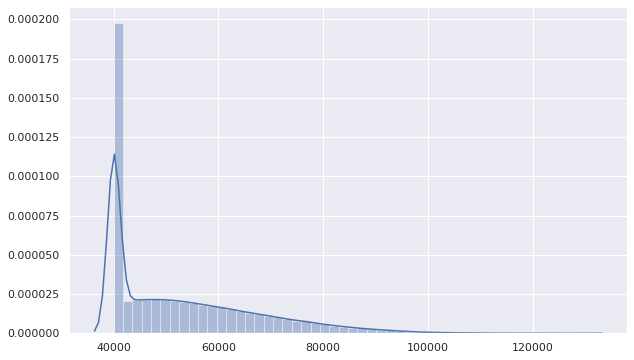

In [30]:
sns.set(rc={"figure.figsize": (10, 6)})
sns.distplot(salaries.select('salary').toPandas(), norm_hist=True)
plt.show()

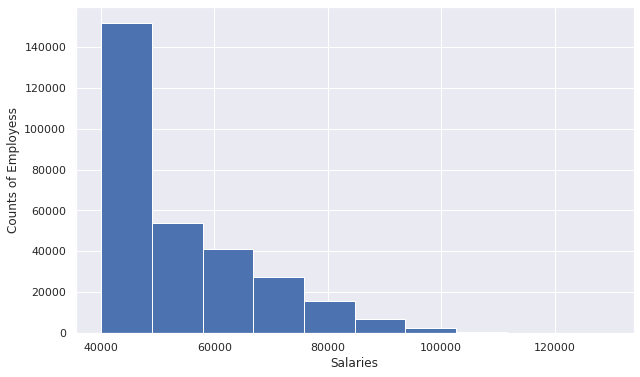

In [31]:
plt.hist(salaries.select('salary').toPandas().values)
plt.xlabel('Salaries')
plt.ylabel('Counts of Employess')
plt.show()

## **10. Bar graph to show the Average salary per title (designation)**

In [32]:
q10 = spark.sql("""
            SELECT 
                t.title, 
                avg(Salary) Avg_Salary, 
                max(Salary) Max_Salary, 
                min(Salary) Min_Salary
            FROM salaries s
            JOIN employees e ON s.emp_no = e.emp_no
            JOIN titles t ON e.emp_title_id = t.title_id
            GROUP BY t.title
         """).toPandas()
q10.head(10)

,title,Avg_Salary,Max_Salary,Min_Salary
0,Staff,58465.382850,129492,40000
1,Assistant Engineer,48564.434447,99683,40000
2,Senior Staff,58550.172704,127238,40000
3,Senior Engineer,48506.799871,110449,40000
4,Engineer,48535.336511,100683,40000
5,Manager,51531.041667,72446,40000
6,Technique Leader,48582.896092,104065,40000


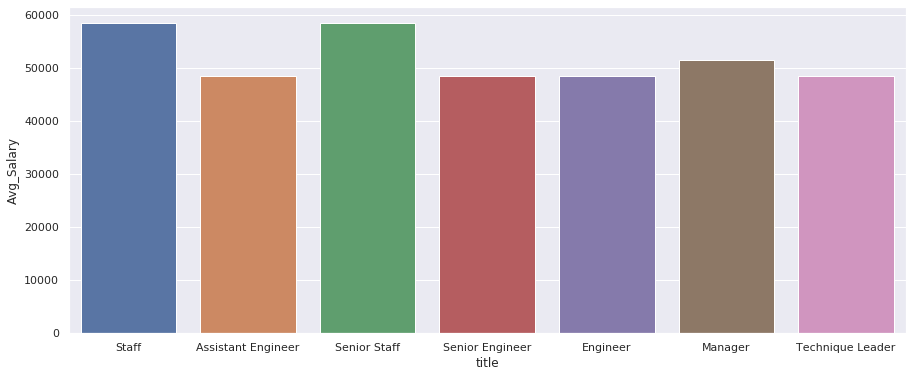

In [33]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.barplot(data=q10, x='title', y='Avg_Salary')
plt.show()

## **11. Calculate employee tenure & show the tenure distribution among the employees**

In [34]:
q11 = spark.sql("""
           SELECT 
                CASE WHEN last_date IS NULL 
                     THEN (SELECT year(greatest(max(last_date), max(hire_date))) FROM employees)-year(hire_date)
                ELSE year(last_date)-year(hire_date) END AS Tenure_Years, 
                count(*) AS Tenure_cnt
            FROM employees
            GROUP BY Tenure_Years
            ORDER BY Tenure_cnt DESC
         """).toPandas()
q11.head()

,Tenure_Years,Tenure_cnt
0,27,32530
1,28,31832
2,26,30175
3,25,28210
4,24,25607


In [35]:
employees.groupBy('Tenure_Years').agg(count('emp_no').alias('Tenure_cnt'))\
    .orderBy(col('Tenure_cnt').desc()).toPandas().head()

,Tenure_Years,Tenure_cnt
0,27,32530
1,28,31832
2,26,30175
3,25,28210
4,24,25607


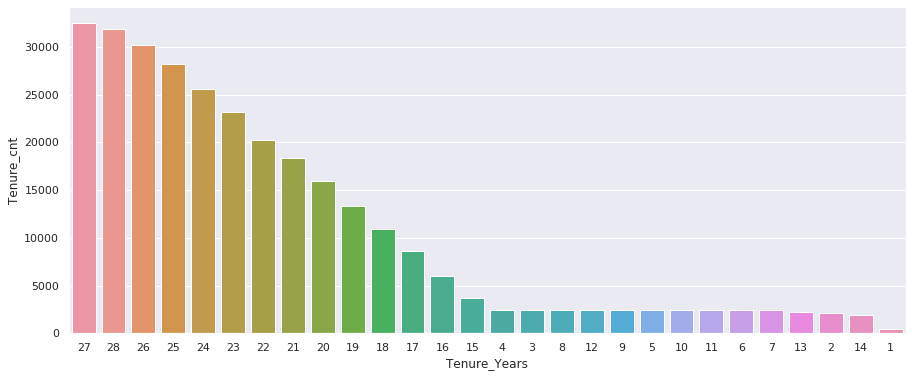

In [36]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.barplot(data=q11, x='Tenure_Years', y='Tenure_cnt',\
           order=q11.sort_values('Tenure_cnt',ascending = False).Tenure_Years)
plt.show()

## **12. Count of Employee Status (Currently working or Left) in different departments grouped by gender**

In [37]:
spark.sql("""
            SELECT
                dept_name, sex,
                count(Left2) Total_Count,
                sum(CASE WHEN Left2 = 0 THEN 1 ELSE 0 END) Working_Count,
                sum(Left2) Left_Count
            FROM Employees e
            JOIN dept_emp de ON e.emp_no = de.emp_no
            JOIN departments d ON de.dept_no = d.dept_no
            GROUP BY dept_name, sex
         """).show()

+------------------+---+-----------+-------------+----------+
|         dept_name|sex|Total_Count|Working_Count|Left_Count|
+------------------+---+-----------+-------------+----------+
|Quality Management|  M|      12039|        10839|      1200|
|           Finance|  F|       5961|         5388|       573|
|   Human Resources|  M|      10711|         9635|      1076|
|Quality Management|  F|       8078|         7260|       818|
|   Human Resources|  F|       7075|         6354|       721|
|             Sales|  M|      29810|        26755|      3055|
|  Customer Service|  M|      14132|        12713|      1419|
|       development|  M|      47277|        42512|      4765|
|         Marketing|  F|       5850|         5304|       546|
|          Research|  F|       8439|         7601|       838|
|        Production|  F|      23912|        21460|      2452|
|          Research|  M|      12687|        11427|      1260|
|           Finance|  M|       8756|         7929|       827|
|       

# 13. Max, Min and Avg age of Employees in diffrent departments

In [38]:
spark.sql("""
           SELECT dept_name, min(Age), max(Age), avg(Age)
           FROM (
            SELECT
                dept_name, e.emp_no,
                    (SELECT year(greatest(max(last_date), max(hire_date))) FROM Employees)-year(birth_date) Age
            FROM employees e
            JOIN dept_emp de ON e.emp_no = de.emp_no
            JOIN departments d ON de.dept_no = d.dept_no 
            )a
          GROUP BY dept_name
         """).show()

+------------------+--------+--------+------------------+
|         dept_name|min(Age)|max(Age)|          avg(Age)|
+------------------+--------+--------+------------------+
|             Sales|      48|      61| 54.91617164374459|
|Quality Management|      48|      61| 54.94397773027787|
|           Finance|      48|      61|  54.9266154786981|
|        Production|      48|      61| 54.93388693708081|
|          Research|      48|      61|54.902821168228726|
|  Customer Service|      48|      61| 54.91675148430873|
|         Marketing|      48|      61| 54.92153161655656|
|       development|      48|      61|  54.8962446324669|
|   Human Resources|      48|      61| 54.94900483526369|
+------------------+--------+--------+------------------+



The Age group distribution is very uniform accross all the departments. 

# 14. Count of Employees in various titles

In [39]:
q14 = spark.sql("""
            SELECT 
                t.title, 
                count(Salary) Emp_Count
            FROM salaries s
            JOIN employees e ON s.emp_no = e.emp_no
            JOIN titles t ON e.emp_title_id = t.title_id
            GROUP BY t.title
            ORDER BY Emp_Count DESC
         """).toPandas()
q14.head(10)

,title,Emp_Count
0,Staff,107384
1,Senior Engineer,97747
2,Engineer,47303
3,Senior Staff,26583
4,Technique Leader,15148
5,Assistant Engineer,5835
6,Manager,24


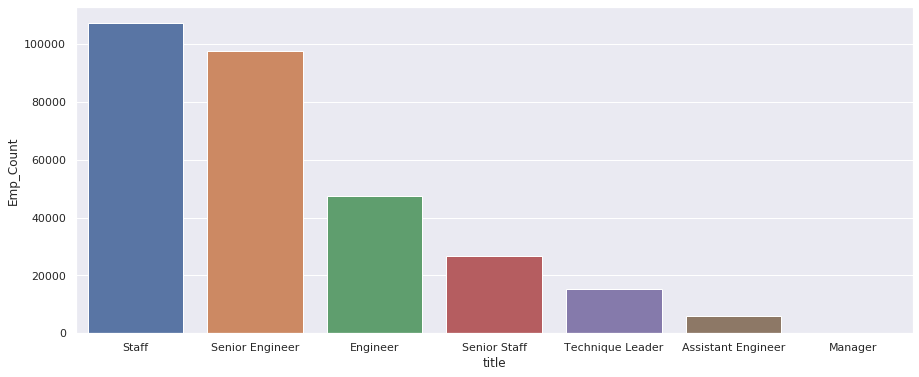

In [40]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.barplot(data=q14, x='title', y='Emp_Count')
plt.show()

# 15 Average Tenure Distribution accross Departments

In [41]:
q15 = spark.sql("""
            SELECT 
                dept_name, 
                avg(Tenure_Years) Tenure
            FROM employees_at e
            JOIN dept_emp de ON e.emp_no = de.emp_no
            JOIN departments d ON de.dept_no = d.dept_no
            GROUP BY dept_name
            ORDER BY Tenure DESC
         """).toPandas()
q15.head(10)

,dept_name,Tenure
0,Finance,21.911123
1,Marketing,21.899285
2,Research,21.864480
3,Production,21.835213
4,Sales,21.832484
5,development,21.829598
6,Quality Management,21.800517
7,Customer Service,21.790967
8,Human Resources,21.787473


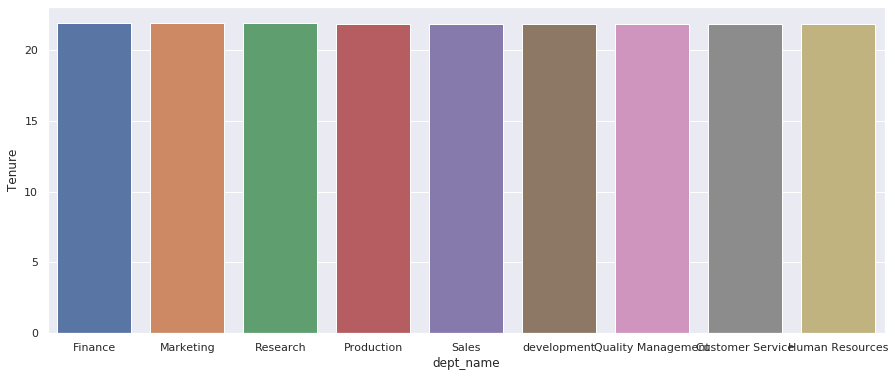

In [42]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.barplot(data=q15, x='dept_name', y='Tenure')
plt.show()

# 16 Average Tenure Distribution accross Titles

In [43]:
q16 = spark.sql("""
            SELECT 
                title, 
                avg(Tenure_Years) Tenure
            FROM employees_at e
            JOIN titles t ON e.emp_title_id = t.title_id
            GROUP BY title
            ORDER BY Tenure DESC
         """).toPandas()
q16.head(10)

,title,Tenure
0,Manager,24.666667
1,Senior Engineer,22.490163
2,Senior Staff,21.867961
3,Staff,21.830664
4,Technique Leader,21.810536
5,Engineer,20.638416
6,Assistant Engineer,20.470094


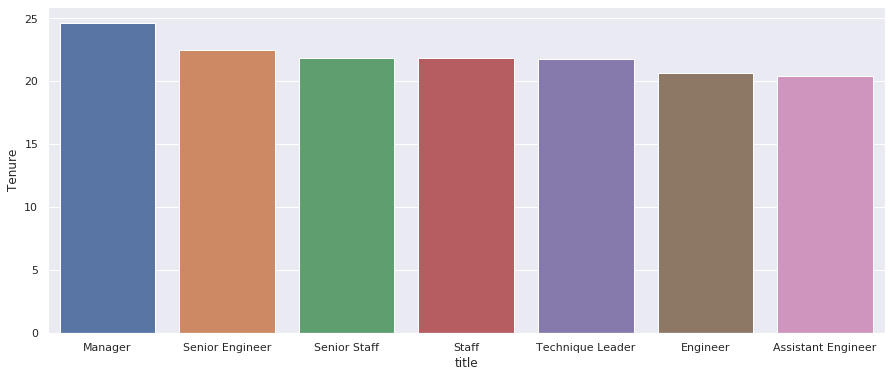

In [44]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.barplot(data=q16, x='title', y='Tenure')
plt.show()

# **Building Spark ML Model and Pipeline**

## **Creating Final Dataframe**

In [45]:
# Joining employees, salaries, departments, titles
emp_tsd = employees.join(titles, employees.emp_title_id == titles.title_id)\
    .join(salaries, on='emp_no')\
    .join(dept_emp, on='emp_no')\
    .join(departments, on='dept_no')\
    .withColumnRenamed('left2', 'left')
emp_tsd.toPandas().head(10)

,dept_no,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,no_of_projects,last_performance_rating,left,last_date,Age,Tenure_Years,title_id,title,salary,dept_name
0,d005,10001,e0003,1953-09-02,Georgi,Facello,M,1986-06-26,9,C,1,1994-07-30,60,8,e0003,Senior Engineer,60117,development
1,d007,10002,s0001,1964-06-02,Bezalel,Simmel,F,1985-11-21,8,B,0,None,49,28,s0001,Staff,65828,Sales
2,d004,10003,e0003,1959-12-03,Parto,Bamford,M,1986-08-28,1,C,0,None,54,27,e0003,Senior Engineer,40006,Production
3,d004,10004,e0003,1954-05-01,Chirstian,Koblick,M,1986-12-01,5,A,0,None,59,27,e0003,Senior Engineer,40054,Production
4,d003,10005,s0001,1955-01-21,Kyoichi,Maliniak,M,1989-09-12,6,A,0,None,58,24,s0001,Staff,78228,Human Resources
5,d005,10006,e0003,1953-04-20,Anneke,Preusig,F,1989-06-02,10,B,0,None,60,24,e0003,Senior Engineer,40000,development
6,d008,10007,s0001,1957-05-23,Tzvetan,Zielinski,F,1989-02-10,6,B,1,2002-09-18,56,13,s0001,Staff,56724,Research
7,d005,10008,e0001,1958-02-19,Saniya,Kalloufi,M,1994-09-15,9,C,0,None,55,19,e0001,Assistant Engineer,46671,development
8,d006,10009,e0003,1952-04-19,Sumant,Peac,F,1985-02-18,8,B,0,None,61,28,e0003,Senior Engineer,60929,Quality Management
9,d006,10010,e0002,1963-06-01,Duangkaew,Piveteau,F,1989-08-24,4,A,0,None,50,24,e0002,Engineer,72488,Quality Management


In [46]:
emp_tsd.count()

300024

In [47]:
dfp = emp_tsd.toPandas()
dfp.dtypes

dept_no                    object
emp_no                      int32
emp_title_id               object
birth_date                 object
first_name                 object
last_name                  object
sex                        object
hire_date                  object
no_of_projects              int32
last_performance_rating    object
left                        int32
last_date                  object
Age                         int32
Tenure_Years                int32
title_id                   object
title                      object
salary                      int32
dept_name                  object
dtype: object

In [48]:
conti_var_df = dfp.loc[:, (dfp.dtypes == 'float64') | (dfp.dtypes == 'int64') | (dfp.dtypes == 'int32')]
cat_var_df = dfp.loc[:, (dfp.dtypes == 'object')]

### Continous Variables

In [49]:
def fun_describe(x):

    # Records and missing values
    n_tot = x.shape[0]
    n_count = x.count()
    n_miss = x.isna().sum()
    n_miss_perc = n_miss / n_tot

    # IQR
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr

    return pd.Series(data=[
        x.dtypes, n_tot, n_count, n_miss, n_miss_perc,
        x.nunique(),
        x.sum(),
        x.mean(),
        x.std(),
        x.var(), iqr, lc_iqr, uc_iqr,
        x.min(),
        x.max(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.1),
        x.quantile(0.25),
        x.quantile(0.5),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99)
    ],
        index=[
        'dtype', 'tot', 'n', 'nmiss', 'miss_perc',
        'cardinality', 'sum', 'mean', 'std', 'var', 'iqr',
        'lc_iqr', 'uc_iqr', 'min', 'max', 'p1', 'p5', 'p10',
        'p25', 'p50', 'p75', 'p90', 'p95', 'p99'
    ])
conti_var_df.apply(fun_describe).T

,dtype,tot,n,nmiss,miss_perc,cardinality,sum,mean,std,var,iqr,lc_iqr,uc_iqr,min,max,p1,p5,p10,p25,p50,p75,p90,p95,p99
emp_no,int32,300024,300024,0,0,300024,76002608740,253322,161828,2.61884e+10,339986,-424973,934973,10001,499999,13001.2,25002.2,40003.3,85006.8,249988,424993,469997,484998,496999
no_of_projects,int32,300024,300024,0,0,10,1651580,5.50483,2.87207,8.24881,5,-4.5,15.5,1,10,1,1,2,3,6,8,10,10,10
left,int32,300024,300024,0,0,2,29867,0.0995487,0.299398,0.0896391,0,0,0,0,1,0,0,0,0,0,0,0,1,1
Age,int32,300024,300024,0,0,14,16476763,54.9181,3.74869,14.0527,6,43,67,48,61,49,49,50,52,55,58,60,61,61
Tenure_Years,int32,300024,300024,0,0,28,6550606,21.8336,5.92815,35.1429,6,11,35,1,28,3,8,14,20,23,26,28,28,28
salary,int32,300024,300024,0,0,50355,15892491033,52970.7,14301.5,2.04532e+08,21758,7363,94395,40000,129492,40000,40000,40000,40000,48681,61758,74177,81444.8,94388


Here, 'emp_no' is having numeric datatype but not a variable to be considered as it has maximum cardinality i.e. primary key, used for identification only. 

### Categorical Variables

In [50]:
def fun_obj_describe(x):

    # Records and missing values
    n_tot = x.shape[0]
    n_count = x.count()
    n_miss = x.isna().sum()
    n_miss_perc = n_miss / n_tot

    return pd.Series(data=[
        x.dtypes, n_tot, n_count, n_miss, n_miss_perc,
        x.nunique()
    ],
        index=[
        'dtype', 'tot', 'n', 'nmiss', 'miss_perc',
        'cardinality'
    ])

cat_var_df.apply(fun_obj_describe).T

,dtype,tot,n,nmiss,miss_perc,cardinality
dept_no,object,300024,300024,0,0,9
emp_title_id,object,300024,300024,0,0,7
birth_date,object,300024,300024,0,0,4750
first_name,object,300024,300024,0,0,1276
last_name,object,300024,300024,0,0,1638
sex,object,300024,300024,0,0,2
hire_date,object,300024,300024,0,0,5434
last_performance_rating,object,300024,300024,0,0,5
last_date,object,300024,29867,270157,0.900451,7582
title_id,object,300024,300024,0,0,7


Encoding columns with high cardinality may effect the model, so all of these categorical cols with high cardinality will be dropped later.

## Checking Dependencies

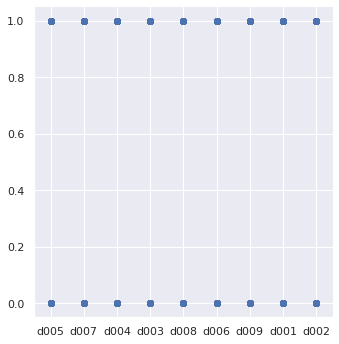

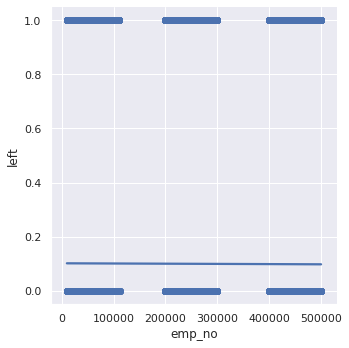

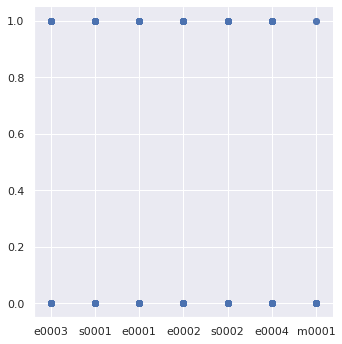

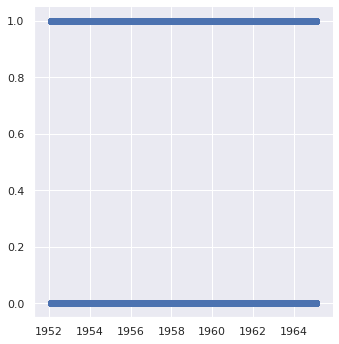

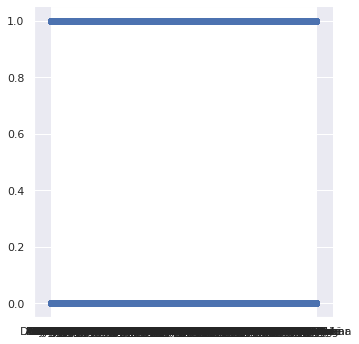

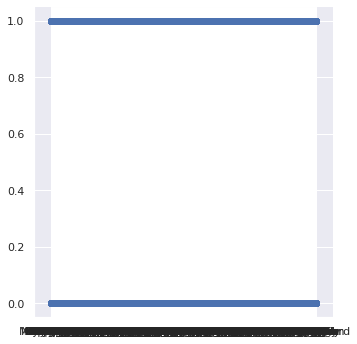

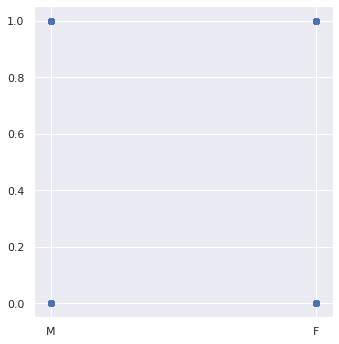

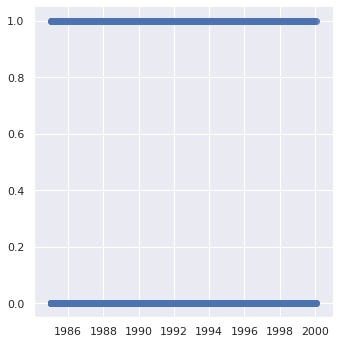

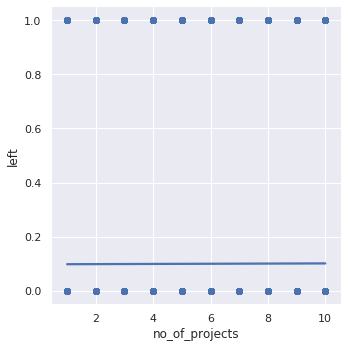

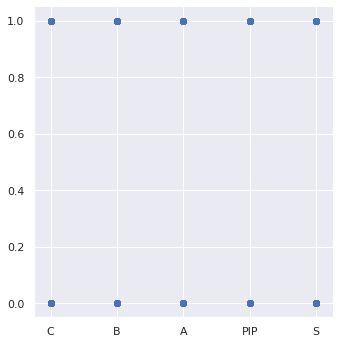

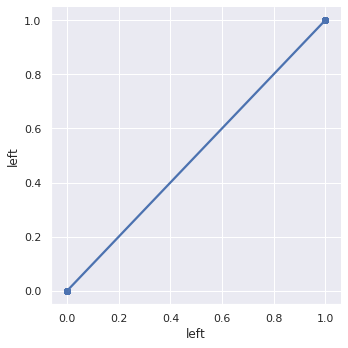

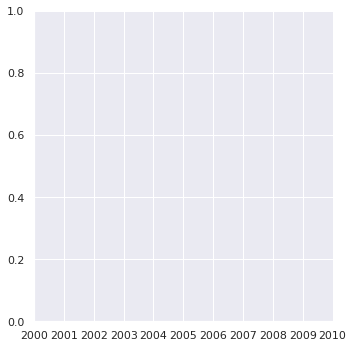

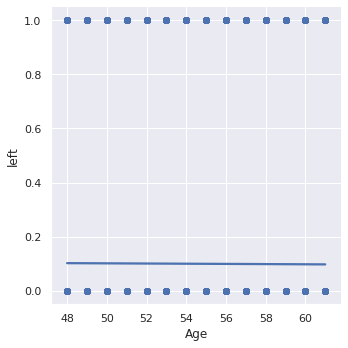

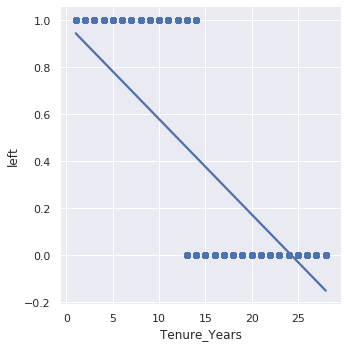

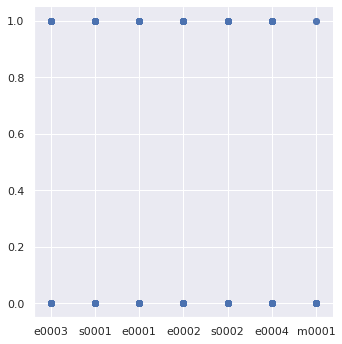

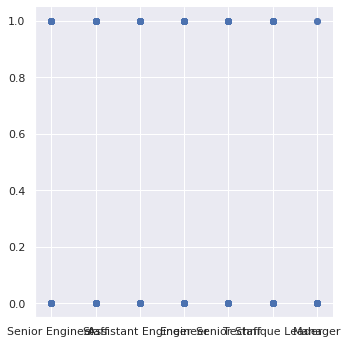

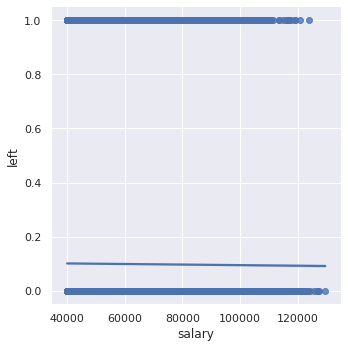

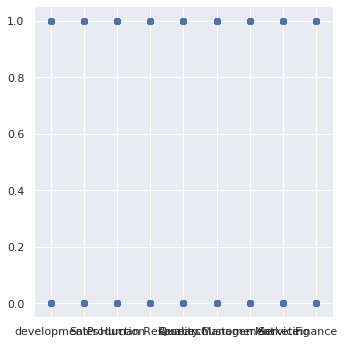

In [51]:
for col in emp_tsd.toPandas().columns:
  try:
    sns.lmplot(x= col, y='left', data=emp_tsd.toPandas())
    plt.show()
  except:
    pass

Dropping these following columns since these do not seem to have any effect in Employee Left Status :
'emp_title_id','birth_date','last_date','hire_date','emp_no','title_id','dept_no','first_name','last_name'

In [52]:
df = emp_tsd.drop('emp_title_id','birth_date','last_date','hire_date'\
                  ,'emp_no','title_id','dept_no','first_name','last_name')
df.toPandas().head(20)

,sex,no_of_projects,last_performance_rating,left,Age,Tenure_Years,title,salary,dept_name
0,M,9,C,1,60,8,Senior Engineer,60117,development
1,F,8,B,0,49,28,Staff,65828,Sales
2,M,1,C,0,54,27,Senior Engineer,40006,Production
3,M,5,A,0,59,27,Senior Engineer,40054,Production
4,M,6,A,0,58,24,Staff,78228,Human Resources
5,F,10,B,0,60,24,Senior Engineer,40000,development
6,F,6,B,1,56,13,Staff,56724,Research
7,M,9,C,0,55,19,Assistant Engineer,46671,development
8,F,8,B,0,61,28,Senior Engineer,60929,Quality Management
9,F,4,A,0,50,24,Engineer,72488,Quality Management


In [53]:
df.printSchema()

root
 |-- sex: string (nullable = true)
 |-- no_of_projects: integer (nullable = true)
 |-- last_performance_rating: string (nullable = true)
 |-- left: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure_Years: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- dept_name: string (nullable = true)



## **Data Preparation for Modeling**

### Label Encoding :

#### last_performance_rating :

In [54]:
df.select('last_performance_rating').distinct().show()

+-----------------------+
|last_performance_rating|
+-----------------------+
|                      B|
|                      C|
|                      A|
|                      S|
|                    PIP|
+-----------------------+



Considering the the order as S > A > B > C > PIP, Encoding values as S = 5, A = 4, B = 3, C = 2, PIP = 1

In [55]:
df = df.withColumn('last_performance_rating', F.when(df.last_performance_rating=='S',5)\
                                               .when(df.last_performance_rating=='A',4)\
                                               .when(df.last_performance_rating=='B',3)\
                                               .when(df.last_performance_rating=='C',2)\
                                               .otherwise(1))

#### title :

In [56]:
df.select('title').distinct().show()

+------------------+
|             title|
+------------------+
|             Staff|
|Assistant Engineer|
|      Senior Staff|
|   Senior Engineer|
|          Engineer|
|           Manager|
|  Technique Leader|
+------------------+



Considering the the order as Staff < Senior Staff < Assistant Engineer < Engineer < Senior Engineer < Technique Leader < Manager, Encoding values as Manager = 7, Technique Leader = 6, Senior Engineer = 5, Engineer = 4, Assistant Engineer = 3, Senior Staff = 2, Staff = 1

In [57]:
df = df.withColumn('title', F.when(df.title=='Manager',7)\
                             .when(df.title=='Technique Leader',6)\
                             .when(df.title=='Senior Engineer',5)\
                             .when(df.title=='Engineer',4)\
                             .when(df.title=='Assistant Engineer',3)\
                             .when(df.title=='Senior Staff',2)\
                             .otherwise(1))

In [58]:
df.show()

+---+--------------+-----------------------+----+---+------------+-----+------+------------------+
|sex|no_of_projects|last_performance_rating|left|Age|Tenure_Years|title|salary|         dept_name|
+---+--------------+-----------------------+----+---+------------+-----+------+------------------+
|  M|             9|                      2|   1| 60|           8|    5| 60117|       development|
|  F|             8|                      3|   0| 49|          28|    1| 65828|             Sales|
|  M|             1|                      2|   0| 54|          27|    5| 40006|        Production|
|  M|             5|                      4|   0| 59|          27|    5| 40054|        Production|
|  M|             6|                      4|   0| 58|          24|    1| 78228|   Human Resources|
|  F|            10|                      3|   0| 60|          24|    5| 40000|       development|
|  F|             6|                      3|   1| 56|          13|    1| 56724|          Research|
|  M|     

In [59]:
# Back_Up df after Label Encoding
df_bkup = df

### One-Hot-Encoding :

In [60]:
#Encoding all categorical features
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoderEstimator

In [61]:
# create object of StringIndexer class and specify input and output column
SI_sex = StringIndexer(inputCol='sex',outputCol='sex_Index')
SI_dept_name = StringIndexer(inputCol='dept_name',outputCol='dept_name_Index')

# transform the data
df = SI_sex.fit(df).transform(df)
df = SI_dept_name.fit(df).transform(df)

# view the transformed data
df.select('sex', 'sex_Index', 'dept_name', 'dept_name_Index').show(10)

+---+---------+------------------+---------------+
|sex|sex_Index|         dept_name|dept_name_Index|
+---+---------+------------------+---------------+
|  M|      0.0|       development|            0.0|
|  F|      1.0|             Sales|            2.0|
|  M|      0.0|        Production|            1.0|
|  M|      0.0|        Production|            1.0|
|  M|      0.0|   Human Resources|            6.0|
|  F|      1.0|       development|            0.0|
|  F|      1.0|          Research|            4.0|
|  M|      0.0|       development|            0.0|
|  F|      1.0|Quality Management|            5.0|
|  F|      1.0|Quality Management|            5.0|
+---+---------+------------------+---------------+
only showing top 10 rows



In [62]:
# create object and specify input and output column
OHE_sex = OneHotEncoderEstimator(inputCols=['sex_Index'],outputCols=['sex_vec'])
OHE_dept_name = OneHotEncoderEstimator(inputCols=['dept_name_Index'],outputCols=['dept_name_vec'])

# transform the data
df = OHE_sex.fit(df).transform(df)
df = OHE_dept_name.fit(df).transform(df)

# view and transform the data
df.select('sex', 'sex_Index','sex_vec', \
          'dept_name', 'dept_name_Index','dept_name_vec').show(10)

+---+---------+-------------+------------------+---------------+-------------+
|sex|sex_Index|      sex_vec|         dept_name|dept_name_Index|dept_name_vec|
+---+---------+-------------+------------------+---------------+-------------+
|  M|      0.0|(1,[0],[1.0])|       development|            0.0|(8,[0],[1.0])|
|  F|      1.0|    (1,[],[])|             Sales|            2.0|(8,[2],[1.0])|
|  M|      0.0|(1,[0],[1.0])|        Production|            1.0|(8,[1],[1.0])|
|  M|      0.0|(1,[0],[1.0])|        Production|            1.0|(8,[1],[1.0])|
|  M|      0.0|(1,[0],[1.0])|   Human Resources|            6.0|(8,[6],[1.0])|
|  F|      1.0|    (1,[],[])|       development|            0.0|(8,[0],[1.0])|
|  F|      1.0|    (1,[],[])|          Research|            4.0|(8,[4],[1.0])|
|  M|      0.0|(1,[0],[1.0])|       development|            0.0|(8,[0],[1.0])|
|  F|      1.0|    (1,[],[])|Quality Management|            5.0|(8,[5],[1.0])|
|  F|      1.0|    (1,[],[])|Quality Management|    

In [63]:
df = df.withColumnRenamed('left', 'label')

In [64]:
df.toPandas().head()

,sex,no_of_projects,last_performance_rating,label,Age,Tenure_Years,title,salary,dept_name,sex_Index,dept_name_Index,sex_vec,dept_name_vec
0,M,9,2,1,60,8,5,60117,development,0.0,0.0,(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,F,8,3,0,49,28,1,65828,Sales,1.0,2.0,(0.0),"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,M,1,2,0,54,27,5,40006,Production,0.0,1.0,(1.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,M,5,4,0,59,27,5,40054,Production,0.0,1.0,(1.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,M,6,4,0,58,24,1,78228,Human Resources,0.0,6.0,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)"


### Assembler :

In [65]:
df.columns

['sex',
 'no_of_projects',
 'last_performance_rating',
 'label',
 'Age',
 'Tenure_Years',
 'title',
 'salary',
 'dept_name',
 'sex_Index',
 'dept_name_Index',
 'sex_vec',
 'dept_name_vec']

In [66]:
assembler = VectorAssembler(inputCols = [
 'no_of_projects',
 'last_performance_rating',
 'Age',
 'Tenure_Years',
 'title',
 'salary',
 'sex_vec',
 'dept_name_vec',], outputCol = "features")

In [67]:
data = assembler.transform(df).select('label','features')
data.show(10, truncate=False)

+-----+---------------------------------------------------------------+
|label|features                                                       |
+-----+---------------------------------------------------------------+
|1    |(15,[0,1,2,3,4,5,6,7],[9.0,2.0,60.0,8.0,5.0,60117.0,1.0,1.0])  |
|0    |(15,[0,1,2,3,4,5,9],[8.0,3.0,49.0,28.0,1.0,65828.0,1.0])       |
|0    |(15,[0,1,2,3,4,5,6,8],[1.0,2.0,54.0,27.0,5.0,40006.0,1.0,1.0]) |
|0    |(15,[0,1,2,3,4,5,6,8],[5.0,4.0,59.0,27.0,5.0,40054.0,1.0,1.0]) |
|0    |(15,[0,1,2,3,4,5,6,13],[6.0,4.0,58.0,24.0,1.0,78228.0,1.0,1.0])|
|0    |(15,[0,1,2,3,4,5,7],[10.0,3.0,60.0,24.0,5.0,40000.0,1.0])      |
|1    |(15,[0,1,2,3,4,5,11],[6.0,3.0,56.0,13.0,1.0,56724.0,1.0])      |
|0    |(15,[0,1,2,3,4,5,6,7],[9.0,2.0,55.0,19.0,3.0,46671.0,1.0,1.0]) |
|0    |(15,[0,1,2,3,4,5,12],[8.0,3.0,61.0,28.0,5.0,60929.0,1.0])      |
|0    |(15,[0,1,2,3,4,5,12],[4.0,4.0,50.0,24.0,4.0,72488.0,1.0])      |
+-----+---------------------------------------------------------

### **Train Test Split**

In [68]:
train_df, test_df = data.randomSplit( [0.7, 0.3], seed = 42 )

## **Model Building**

In [69]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [70]:
# Train Function to build the model and check accuacy
def train(train, test, classifier):
    print(classifier)
    model = classifier.fit(train)

    pred = model.transform(test)

    eval_accuracy = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="accuracy"))

    eval_precision = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedPrecision"))

    eval_recall = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedRecall"))

    eval_f1 = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="f1"))

    accuracy = eval_accuracy.evaluate(pred)

    precision =  eval_precision.evaluate(pred)

    recall =  eval_recall.evaluate(pred)

    f1 =  eval_f1.evaluate(pred)

    print(f"""
    Accuracy  = {accuracy}
    Error     = {1-accuracy}
    Precision = {precision}
    Recall    = {recall}
    F1        = {f1}""")

    return model, pred

# Random Forest Classifier Model

In [71]:
rfc = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')

In [72]:
model_rf, pred_rf = train(train_df, test_df, rfc)
pred_rf.show()

RandomForestClassifier_ce110dc17493

    Accuracy  = 0.9980555834925744
    Error     = 0.001944416507425606
    Precision = 0.9980594815941188
    Recall    = 0.9980555834925743
    F1        = 0.9980471469145747
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(15,[0,1,2,3,4,5]...|[49.3410460390212...|[0.98682092078042...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.4408732192368...|[0.98881746438473...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.4410653136910...|[0.98882130627382...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.3607091886313...|[0.98721418377262...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.4445703932617...|[0.98889140786523...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.6444542333341...|[0.99288908466668...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[49.5585614521556...

### Area under ROC (Random Forest Model)

In [73]:
print('Area under ROC on train dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(model_rf.transform(train_df)))
print('Area under ROC on test dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred_rf))

Area under ROC on train dataset 0.9999458862996691
Area under ROC on test dataset 0.9999469372959502


# Logistic Regression Model

In [74]:
from pyspark.ml.classification import LogisticRegression
mlr = LogisticRegression(maxIter=10, 
                         regParam=0.3, 
                         elasticNetParam=0.8, 
                         family="multinomial")

In [75]:
model_lr, pred_lr = train(train_df, test_df, mlr)
pred_lr.show()

LogisticRegression_b9d5d0551431

    Accuracy  = 0.9004101154357617
    Error     = 0.09958988456423834
    Precision = 0.8107383759790415
    Recall    = 0.9004101154357617
    F1        = 0.8532246480840692
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(15,[0,1,2,3,4,5]...|[1.10238003882660...|[0.90067615376621...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.10018650552051...|[0.90028300239394...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.10091768328921...|[0.90041420637067...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.10347680547964...|[0.90087221183491...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.10128327217355...|[0.90047975076500...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.10164886105790...|[0.90054525678490...|       0.0|
|    0|(15,[0,1,2,3,4,5]...|[1.10274562771095...|[0.9

### Area under ROC (Logistic Regression Model)

In [76]:
print('Area under ROC on train dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(model_lr.transform(train_df)))
print('Area under ROC on test dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred_lr))

Area under ROC on train dataset 0.9999504281834609
Area under ROC on test dataset 0.999949764261694


### Saving the Models to HDFS :

In [77]:
model_rf.write().overwrite().save("random_forest.model")

In [78]:
model_lr.write().overwrite().save("logistic_regression.model")

# **Pipeline**

## Pipeline Stages

In [79]:
# Preparing database  
df = employees.join(titles, employees.emp_title_id == titles.title_id)\
    .join(salaries, on='emp_no')\
    .join(dept_emp, on='emp_no')\
    .join(departments, on='dept_no')\
    .withColumnRenamed('left2', 'label')\
    .drop('emp_title_id','birth_date','last_date','hire_date'\
                  ,'emp_no','title_id','dept_no','first_name','last_name')
# Label Encoding
df_pl = df.withColumn('last_performance_rating', F.when(df.last_performance_rating=='S',5)\
                                               .when(df.last_performance_rating=='A',4)\
                                               .when(df.last_performance_rating=='B',3)\
                                               .when(df.last_performance_rating=='C',2)\
                                               .otherwise(1))\
          .withColumn('title', F.when(df.title=='Manager',7)\
                             .when(df.title=='Technique Leader',6)\
                             .when(df.title=='Senior Engineer',5)\
                             .when(df.title=='Engineer',4)\
                             .when(df.title=='Assistant Engineer',3)\
                             .when(df.title=='Senior Staff',2)\
                             .otherwise(1))
df_pl.show()

+---+--------------+-----------------------+-----+---+------------+-----+------+------------------+
|sex|no_of_projects|last_performance_rating|label|Age|Tenure_Years|title|salary|         dept_name|
+---+--------------+-----------------------+-----+---+------------+-----+------+------------------+
|  M|             9|                      2|    1| 60|           8|    5| 60117|       development|
|  F|             8|                      3|    0| 49|          28|    1| 65828|             Sales|
|  M|             1|                      2|    0| 54|          27|    5| 40006|        Production|
|  M|             5|                      4|    0| 59|          27|    5| 40054|        Production|
|  M|             6|                      4|    0| 58|          24|    1| 78228|   Human Resources|
|  F|            10|                      3|    0| 60|          24|    5| 40000|       development|
|  F|             6|                      3|    1| 56|          13|    1| 56724|          Research|


In [80]:
conCols = [
'no_of_projects',
 'last_performance_rating',
 'Age',
 'Tenure_Years',
 'title',
 'salary']

In [81]:
catCols = ['sex', 'dept_name']

In [82]:
# String Indexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_Index") for column in catCols ]

# One Hot Encoder Estimator
encoders = OneHotEncoderEstimator(inputCols=[i.getOutputCol() for i in indexers], \
                                  outputCols=[i.getOutputCol()+"_vec" for i in indexers])

# Vector Assembler
assembler = VectorAssembler(inputCols = encoders.getOutputCols() + conCols, outputCol = "features")

# ML Models
rfc = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')
mlr = LogisticRegression(maxIter=10, 
                         regParam=0.3, 
                         elasticNetParam=0.8, 
                         family="multinomial")
# Creating Pipelines
pipeline_rfc = Pipeline(stages = indexers + [encoders, assembler, rfc])
pipeline_mlr = Pipeline(stages = indexers + [encoders, assembler, mlr])

In [83]:
train, test = df_pl.randomSplit( [0.7, 0.3], seed = 42 )

## Checking Accuracy, Error, Precision, Recall, F1 Values

In [84]:
def accuracyCheck(pred):
    eval_accuracy = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="accuracy"))

    eval_precision = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedPrecision"))

    eval_recall = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedRecall"))

    eval_f1 = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="f1"))

    accuracy = eval_accuracy.evaluate(pred)

    precision =  eval_precision.evaluate(pred)

    recall =  eval_recall.evaluate(pred)

    f1 =  eval_f1.evaluate(pred)

    print(f"""
    Accuracy  = {accuracy}
    Error     = {1-accuracy}
    Precision = {precision}
    Recall    = {recall}
    F1        = {f1}""")

    return pred

# Random Forest Classifier Model

In [85]:
model_rfc = pipeline_rfc.fit(train)
pred_rfc = model_rfc.transform(test)
pred_rfc = accuracyCheck(pred_rfc)
pred_rfc.select('label', 'features', 'prediction').show(10, truncate=False)


    Accuracy  = 0.9976756400371004
    Error     = 0.0023243599628995915
    Precision = 0.9976805986159328
    Recall    = 0.9976756400371003
    F1        = 0.9976638430104859
+-----+-------------------------------------------------------------+----------+
|label|features                                                     |prediction|
+-----+-------------------------------------------------------------+----------+
|0    |(15,[1,9,10,11,12,13,14],[1.0,1.0,1.0,48.0,24.0,5.0,50527.0])|0.0       |
|0    |(15,[1,9,10,11,12,13,14],[1.0,1.0,1.0,48.0,25.0,4.0,40000.0])|0.0       |
|0    |(15,[2,9,10,11,12,13,14],[1.0,1.0,1.0,48.0,27.0,4.0,58610.0])|0.0       |
|0    |(15,[2,9,10,11,12,13,14],[1.0,1.0,1.0,49.0,21.0,3.0,40000.0])|0.0       |
|0    |(15,[4,9,10,11,12,13,14],[1.0,1.0,1.0,49.0,23.0,1.0,47408.0])|0.0       |
|0    |(15,[2,9,10,11,12,13,14],[1.0,1.0,1.0,49.0,25.0,4.0,40000.0])|0.0       |
|0    |(15,[2,9,10,11,12,13,14],[1.0,1.0,1.0,49.0,25.0,5.0,40000.0])|0.0       |
|0    |(15,

### Area under ROC (Random Forest Model)

In [86]:
print('Area under ROC on train dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(model_rfc.transform(train)))
print('Area under ROC on test dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred_rfc))

Area under ROC on train dataset 0.9999525956543478
Area under ROC on test dataset 0.9999157516113358


# Logistic Regression Model

In [87]:
model_mlr = pipeline_mlr.fit(train)
pred_mlr = model_mlr.transform(test)
pred_mlr = accuracyCheck(pred_mlr)
pred_mlr.select('label', 'features', 'prediction').show(10, truncate=False)


    Accuracy  = 0.8998960742901203
    Error     = 0.1001039257098797
    Precision = 0.8098129445227698
    Recall    = 0.8998960742901203
    F1        = 0.8524813072476602
+-----+-------------------------------------------------------------+----------+
|label|features                                                     |prediction|
+-----+-------------------------------------------------------------+----------+
|0    |(15,[1,9,10,11,12,13,14],[1.0,1.0,1.0,48.0,24.0,5.0,50527.0])|0.0       |
|0    |(15,[1,9,10,11,12,13,14],[1.0,1.0,1.0,48.0,25.0,4.0,40000.0])|0.0       |
|0    |(15,[2,9,10,11,12,13,14],[1.0,1.0,1.0,48.0,27.0,4.0,58610.0])|0.0       |
|0    |(15,[2,9,10,11,12,13,14],[1.0,1.0,1.0,49.0,21.0,3.0,40000.0])|0.0       |
|0    |(15,[4,9,10,11,12,13,14],[1.0,1.0,1.0,49.0,23.0,1.0,47408.0])|0.0       |
|0    |(15,[2,9,10,11,12,13,14],[1.0,1.0,1.0,49.0,25.0,4.0,40000.0])|0.0       |
|0    |(15,[2,9,10,11,12,13,14],[1.0,1.0,1.0,49.0,25.0,5.0,40000.0])|0.0       |
|0    |(15,[4,

### Area under ROC (Logistic Regression Model)

In [88]:
print('Area under ROC on train dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(model_mlr.transform(train)))
print('Area under ROC on test dataset',BinaryClassificationEvaluator(labelCol="label", \
        rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred_mlr))

Area under ROC on train dataset 0.9999554346690951
Area under ROC on test dataset 0.9999374877649229


The Accuracies between the built models and the Pipeline models are very close. The reason behind the slight change in the accuracies is that the eariler case, the train & test split was performed after fitting the assembler but in case of ML pipeline, the assembler is inside the stages so assembler is fitting on split datasets seperately as a part of the pipeline. This is also clearly visible in the features column as well. So, this was a good test of the pipeline models in terms of accuracy and we can conclude that the ML Pipeline is working properly.

#### -End-